# Pytorch音频处理
原文：https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html  
Pytorch Audio Processing使用[torchaudio](https://github.com/pytorch/audio)这个库。

In [36]:
import matplotlib.pyplot as plt
import torchaudio

# 打开一个音频文件

Shape of waveform: torch.Size([2, 672096])
Sample rate of waveform: 16000


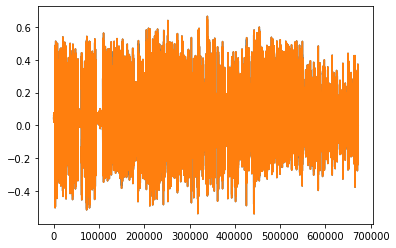

In [37]:
# 音频文件的双声道很接近，所以图上波形边缘有不太明显的两个颜色。
filename = 'data/diarizationExample_sr16k_ac2.wav'
waveform, sample_rate = torchaudio.load(filename)

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.figure()
plt.plot(waveform.t().numpy())
plt.show()

# 转换(Transformations)
torchaudio支持的转换列表还在增长中，[这里查看](https://pytorch.org/audio/transforms.html)。
- 重采样(Resample): Resample waveform to a different sample rate.
- 频谱图(Spectrogram): Create a spectrogram from a waveform.
- 梅尔刻度(MelScale): This turns a normal STFT into a Mel-frequency STFT, using a conversion matrix.
- 振幅转分贝(AmplitudeToDB): This turns a spectrogram from the power/amplitude scale to the decibel scale.
- 梅尔频率倒谱系数(MFCC): Create the Mel-frequency cepstrum coefficients from a waveform.
- 梅尔频谱图(MelSpectrogram): Create MEL Spectrograms from a waveform using the STFT function in PyTorch.
- μ-law编码(MuLawEncoding): Encode waveform based on mu-law companding. 原理与为何增加SNR参考这篇：https://www.mahong.me/archives/13
- μ-law解码(MuLawDecoding): Decode mu-law encoded waveform.

首先，在对数刻度上查看频谱图的对数。

Shape of spectrogram: torch.Size([2, 201, 3361])


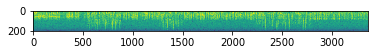

In [38]:
specgram = torchaudio.transforms.Spectrogram()(waveform)

# 双声道的音频
print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy())
plt.show()

或者，可以以对数刻度查看梅尔频谱图。

Shape of spectrogram: torch.Size([2, 128, 3361])


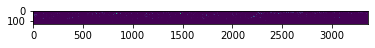

In [39]:
specgram = torchaudio.transforms.MelSpectrogram()(waveform)
print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
# MelSpectrogram的接口返回的跟其它几个不一样，还得detach()生成一个不需要求导的张量。
# tensor.detach() creates a tensor that shares storage with tensor that does not require grad.
# Ref: https://discuss.pytorch.org/t/clone-and-detach-in-v0-4-0/16861/2
plt.imshow(specgram.detach()[0, :, :].numpy())
plt.show()

可以对音频进行频率重采样，一次操作一个声道。

Shape of transformed waveform: torch.Size([1, 67210])


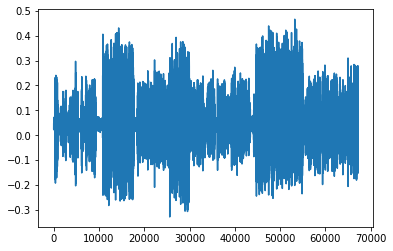

In [40]:
new_sample_rate = sample_rate/10
# 这里对第一个声道进行重采样
channel = 0
# view(1, -1)是将waveform[channel,:]这个一维数组重新组装为二维数组。
transformed = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(waveform[channel,:].view(1, -1))
print("Shape of transformed waveform: {}".format(transformed.size()))

plt.figure()
plt.plot(transformed[0, :].numpy())
plt.show()

μ-law编码。μ-law编码要求信号的数值在-1与1之间，因为上面生成的waveform张量是常规的Pytorch张量，因此这里可以对其进行直接操作。

In [41]:
# 检查信号数值是否在区间[-1,1]中
print("Min: {}\nMax: {}\nMean: {}".format(waveform.min(), waveform.max(), waveform.mean()))

Min: -0.5394287109375
Max: 0.664764404296875
Mean: 0.04157630726695061


如上所示，信号已经在区间[-1, 1]，因此不需要再正则化。

In [42]:
def normalize(tensor):
    # 减去平均值，并缩放到区间[-1,1]
    tensor_minusmean = tensor - tensor.mean()
    return tensor_minusmean/tensor_minusmean.abs().max()
# 归一化为[-1,1]
# waveform = normalize(waveform)

对waveform进行μ-law编码。
一般来说语音信号是符合拉普拉斯分布的，当我们使用线性量化的时候则会造成一些不必要的量化等级的浪费。
因此，可以将信号先进行放大，使其的pdf（概率密度函数）分布发生改变，变得更加的均匀，然后再进行量化反转，从而得到最终的信号。(参考https://www.mahong.me/archives/13)

Shape of transformed waveform: torch.Size([2, 672096])


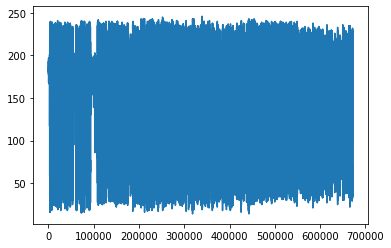

In [43]:
transformed = torchaudio.transforms.MuLawEncoding()(waveform)
print("Shape of transformed waveform: {}".format(transformed.size()))

plt.figure()
plt.plot(transformed[0, :].numpy())
plt.show()

μ-law解码。

Shape of recovered waveform: torch.Size([2, 672096])


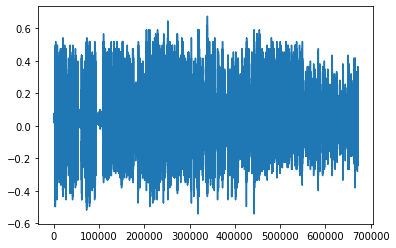

In [52]:
reconstructed = torchaudio.transforms.MuLawDecoding()(transformed)
print("Shape of recovered waveform: {}".format(reconstructed.size()))

plt.figure()
plt.plot(reconstructed[0, :].numpy())
plt.show()

最后，对比原始waveform与经过μ-law编解码重建后的waveform。

In [45]:
# 计算中位数相对差
err = ((waveform-reconstructed).abs()/waveform.abs()).median()
print("Median relative difference between original and Mulaw rconstructed signals :{:.2%}".format(err))

Median relative difference between original and Mulaw rconstructed signals :1.22%


# 从Kaldi迁移至torchaudio
Kaldi是活跃的语音识别工作集，torchaudio通过`torchaudio.kaldi_io`提供与其的兼容性。
实际上它可以通过以下方式从Kaldi scp、ark文件或流中读取内容：
- read_vec_int_ark
- read_vec_flt_scp
- read_vec_flt_arkfile/stream
- read_mat_scp
- read_mat_ark

torchaudio为频谱图(spectrogram)与过滤器组(fbank)提供与Kaldi兼容的转换(transform)，[参见此处](https://pytorch.org/tutorials/beginner/compliance.kaldi.html)获取更多信息。

Shape of spectrogram: torch.Size([3359, 201])


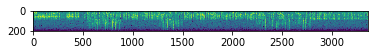

In [46]:
n_fft = 400.0
frame_length = n_fft / sample_rate * 1000.0
frame_shift = frame_length / 2.0

params = {
    "channel": 0,
    "dither": 0.0,
    "window_type": "hanning",
    "frame_length": frame_length,
    "frame_shift": frame_shift,
    "remove_dc_offset": False,
    "round_to_power_of_two": False,
    "sample_frequency": sample_rate,
}

specgram = torchaudio.compliance.kaldi.spectrogram(waveform, **params)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
plt.imshow(specgram.t().numpy())
plt.show()

torchaudio还支持根据波形(waveform)计算滤波器组(filterbank)的功能，以匹配Kaldi的实现。

Shape of fbank: torch.Size([3359, 23])


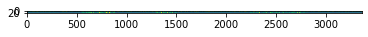

In [50]:
fbank = torchaudio.compliance.kaldi.fbank(waveform, **params)
print("Shape of fbank: {}".format(fbank.size()))

plt.figure()
plt.imshow(fbank.t().numpy())
plt.show()

# 小结
本文以原始音频信号(raw audio signal)或波形(waveform)为例，来说明如何使用torchaudio打开音频文件，以及如何预处理和转换（transform）此类波形。鉴于torchaudio是基于Pytorch构建的，这些技术可在利用GPU的同时作为更高级音频应用（例如语音识别）的构建块。